In [1]:
# ==============================================================================
# ETAPA 1: CARREGAMENTO E CONSOLIDAÇÃO DOS DADOS
# ==============================================================================
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("--- Etapa 1: Carregando e Consolidando Dados ---")

# Listar arquivos de dados e dicionário
data_files = sorted(glob.glob("Dados/*_Base_de_Dados.csv"))
dictionary_files = sorted(glob.glob("Dados/*_Dicionario_de_Dados*.csv"))

# Carregar e concatenar todos os arquivos de dados
list_of_dfs = []
for file in data_files:
    try:
        df = pd.read_csv(file, sep=';', on_bad_lines='warn')
        list_of_dfs.append(df)
    except UnicodeDecodeError:
        df = pd.read_csv(file, sep=';', on_bad_lines='warn', encoding='latin1')
        list_of_dfs.append(df)

full_df = pd.concat(list_of_dfs, ignore_index=True)
full_df.to_csv("consolidated_dataset.csv", index=False, sep=';')

print(f"Dataset consolidado criado com {len(full_df)} registros.")
print(full_df.info())
print("\n")




--- Etapa 1: Carregando e Consolidando Dados ---


/tmp/ipykernel_539180/2475952333.py:29: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep=';', on_bad_lines='warn', encoding='latin1')


Dataset consolidado criado com 497663 registros.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497663 entries, 0 to 497662
Data columns (total 42 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Data do Atendimento                           497663 non-null  object 
 1   Data de Nascimento                            497663 non-null  object 
 2   Sexo                                          497663 non-null  object 
 3   Código do Tipo de Unidade                     497663 non-null  int64  
 4   Tipo de Unidade                               497663 non-null  object 
 5   Código da Unidade                             497663 non-null  int64  
 6   Descrição da Unidade                          497663 non-null  object 
 7   Código do Procedimento                        497663 non-null  int64  
 8   Descrição do Procedimento                     497663 non-null  object 
 9  

In [2]:
# ==============================================================================
# ETAPA 2: LIMPEZA E PREPARAÇÃO DOS DADOS
# ==============================================================================
print("--- Etapa 2: Limpeza e Preparação dos Dados ---")

# 1. Remover Colunas Vazias
columns_to_drop = [
    'Código do CID', 'Descrição do CID', 'Data do Internamento',
    'Estabelecimento Solicitante', 'Estabelecimento Destino', 'CID do Internamento'
]
df_cleaned = full_df.drop(columns=columns_to_drop)

# 2. Tratar Valores Ausentes
categorical_cols_with_nan = [
    'Área de Atuação', 'Tratamento no Domicílio', 'Abastecimento',
    'Tipo de Habitação', 'Destino Lixo', 'Fezes/Urina', 'Em Caso de Doença',
    'Grupo Comunitário', 'Meio de Comunicacao', 'Meio de Transporte'
]
for col in categorical_cols_with_nan:
    df_cleaned[col] = df_cleaned[col].fillna("Não Informado")

median_comodos = df_cleaned['Cômodos'].median()
df_cleaned['Cômodos'] = df_cleaned['Cômodos'].fillna(median_comodos)

# 3. Corrigir Tipos de Dados
df_cleaned['Data do Atendimento'] = pd.to_datetime(df_cleaned['Data do Atendimento'], dayfirst=True, errors='coerce')
df_cleaned['Data de Nascimento'] = pd.to_datetime(df_cleaned['Data de Nascimento'], dayfirst=True, errors='coerce')
df_cleaned['Cômodos'] = df_cleaned['Cômodos'].astype(int)

# 4. Criar a coluna 'Idade' 
# Primeiro, calculamos a diferença, que resulta em Timedelta
time_difference = df_cleaned['Data do Atendimento'] - df_cleaned['Data de Nascimento']
# Depois, convertemos essa diferença para dias e dividimos por 365.25
df_cleaned['Idade'] = (time_difference.dt.days / 365.25)

# Remover quaisquer valores nulos ou negativos que possam surgir de datas inválidas
df_cleaned.dropna(subset=['Idade'], inplace=True)
df_cleaned = df_cleaned[df_cleaned['Idade'] >= 0]
df_cleaned['Idade'] = df_cleaned['Idade'].astype(int)


df_cleaned.to_csv("cleaned_dataset.csv", index=False, sep=';')
print("Dataset limpo salvo como 'cleaned_dataset.csv'")
print(df_cleaned.info())
print("\n")




--- Etapa 2: Limpeza e Preparação dos Dados ---
Dataset limpo salvo como 'cleaned_dataset.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497663 entries, 0 to 497662
Data columns (total 37 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Data do Atendimento                           497663 non-null  datetime64[ns]
 1   Data de Nascimento                            497663 non-null  datetime64[ns]
 2   Sexo                                          497663 non-null  object        
 3   Código do Tipo de Unidade                     497663 non-null  int64         
 4   Tipo de Unidade                               497663 non-null  object        
 5   Código da Unidade                             497663 non-null  int64         
 6   Descrição da Unidade                          497663 non-null  object        
 7   Código do Procedimento                    

--- Etapa 3: Análise Exploratória e Gráficos ---


/tmp/ipykernel_539180/1617826545.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cbo_counts.values, y=cbo_counts.index, palette='viridis', orient='h')


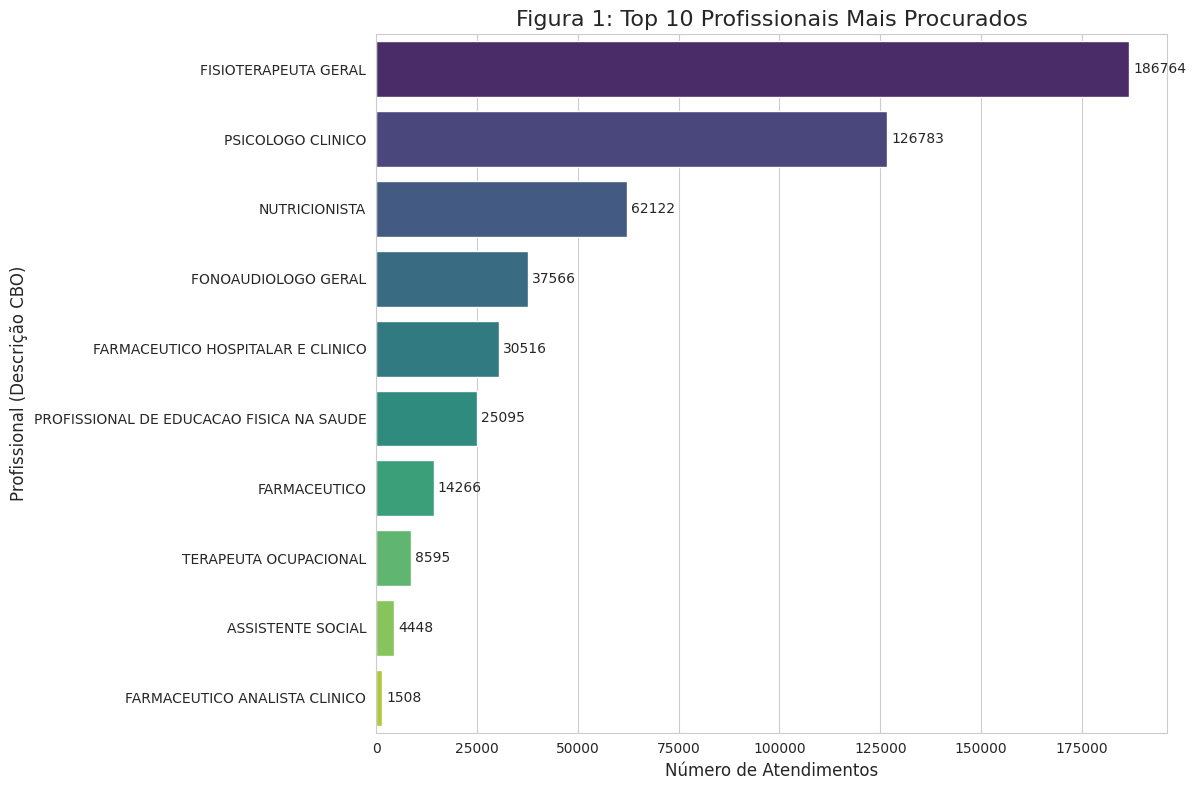

/tmp/ipykernel_539180/1617826545.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=day_counts.index, y=day_counts.values, palette='plasma', order=day_counts.index)


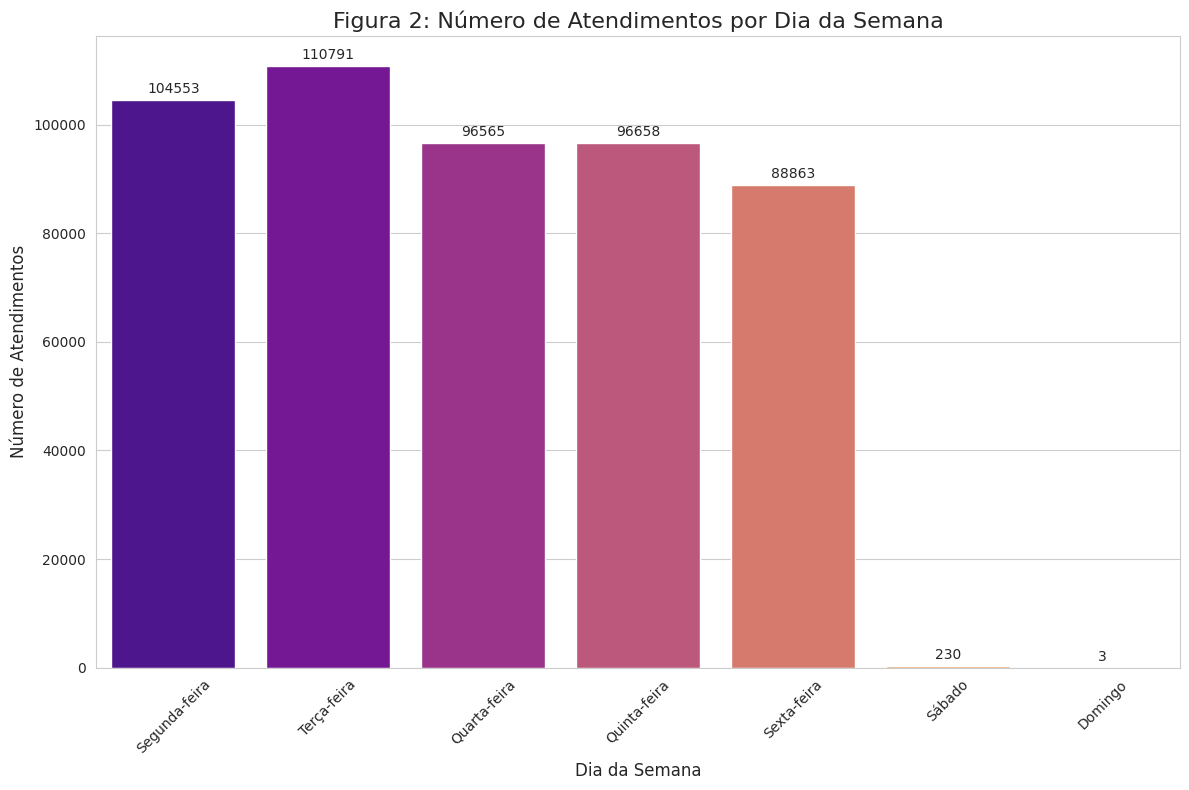

/tmp/ipykernel_539180/1617826545.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='magma', orient='h')


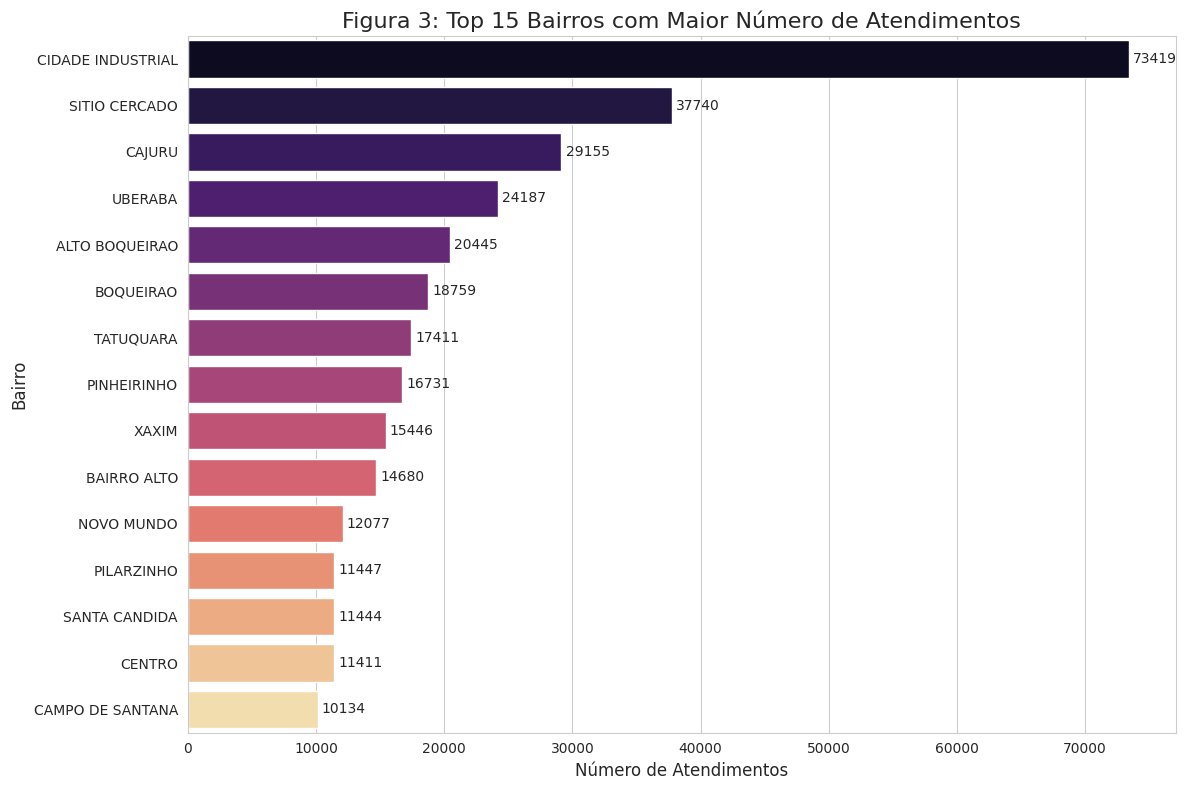

In [3]:
# ==============================================================================
# ETAPA 3: ANÁLISE EXPLORATÓRIA E GERAÇÃO DE GRÁFICOS
# ==============================================================================
print("--- Etapa 3: Análise Exploratória e Gráficos ---")

df = pd.read_csv("cleaned_dataset.csv", sep=';')
df['Data do Atendimento'] = pd.to_datetime(df['Data do Atendimento'])

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.autolayout'] = True

# Gráfico 1: Profissionais Mais Procurados
plt.figure()
cbo_counts = df['Descrição do CBO'].value_counts().nlargest(15)
ax = sns.barplot(x=cbo_counts.values, y=cbo_counts.index, palette='viridis', orient='h')
ax.set_title('Figura 1: Top 10 Profissionais Mais Procurados', fontsize=16)
ax.set_xlabel('Número de Atendimentos', fontsize=12)
ax.set_ylabel('Profissional (Descrição CBO)', fontsize=12)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=3)
plt.show()

# Gráfico 2: Movimento por Dia da Semana
plt.figure()
df['Dia da Semana'] = df['Data do Atendimento'].dt.day_name()
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days_map_pt = {
    'Monday': 'Segunda-feira', 'Tuesday': 'Terça-feira', 'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira', 'Friday': 'Sexta-feira', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
day_counts = df['Dia da Semana'].value_counts().reindex(days_order)
day_counts.index = day_counts.index.map(days_map_pt)
ax = sns.barplot(x=day_counts.index, y=day_counts.values, palette='plasma', order=day_counts.index)
ax.set_title('Figura 2: Número de Atendimentos por Dia da Semana', fontsize=16)
ax.set_xlabel('Dia da Semana', fontsize=12)
ax.set_ylabel('Número de Atendimentos', fontsize=12)
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=3)
plt.show()

# Gráfico 3: Bairros com Mais Atendimentos
plt.figure()
bairro_counts = df['Bairro'].value_counts().nlargest(15)
ax = sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='magma', orient='h')
ax.set_title('Figura 3: Top 15 Bairros com Maior Número de Atendimentos', fontsize=16)
ax.set_xlabel('Número de Atendimentos', fontsize=12)
ax.set_ylabel('Bairro', fontsize=12)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10, padding=3)
plt.show()
print("\n")




--- Etapa 4: Modelagem Preditiva ---
Modelo treinado.

Acurácia do Modelo: 74.12%

Relatório de Classificação:
                 precision    recall  f1-score   support

Não Encaminhado       0.76      0.93      0.84     47241
    Encaminhado       0.63      0.29      0.40     19753

       accuracy                           0.74     66994
      macro avg       0.70      0.61      0.62     66994
   weighted avg       0.72      0.74      0.71     66994



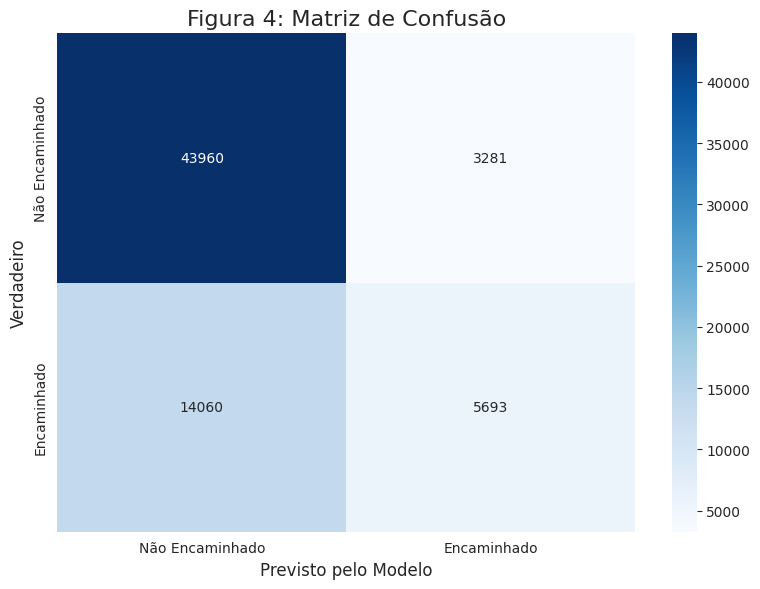

In [4]:
# ==============================================================================
# ETAPA 4: MODELAGEM (REGRESSÃO LOGÍSTICA)
# ==============================================================================
print("--- Etapa 4: Modelagem Preditiva ---")

# 1. Seleção de Atributos e Target
top_cbos = df['Descrição do CBO'].value_counts().nlargest(10).index
top_bairros = df['Bairro'].value_counts().nlargest(10).index
df_model = df[df['Descrição do CBO'].isin(top_cbos) & df['Bairro'].isin(top_bairros)].copy()

features = ['Idade', 'Sexo', 'Descrição do CBO', 'Bairro', 'Solicitação de Exames', 'Cômodos']
target = 'Encaminhamento para Atendimento Especialista'
df_model['target_encoded'] = df_model[target].apply(lambda x: 1 if x == 'Sim' else 0)

X = df_model[features]
y = df_model['target_encoded']

# 2. Pré-processamento e Pipeline
categorical_features = ['Sexo', 'Descrição do CBO', 'Bairro', 'Solicitação de Exames']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# 3. Divisão dos Dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 4. Treinamento do Modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
model.fit(X_train, y_train)
print("Modelo treinado.")

# 5. Avaliação do Modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do Modelo: {accuracy:.2%}")

print("\nRelatório de Classificação:")
target_names = ['Não Encaminhado', 'Encaminhado']
print(classification_report(y_test, y_pred, target_names=target_names))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Figura 4: Matriz de Confusão', fontsize=16)
plt.ylabel('Verdadeiro', fontsize=12)
plt.xlabel('Previsto pelo Modelo', fontsize=12)
plt.show()

In [5]:
# Estava querendo visualizar se conseguiria correlacionar o número de usuários que usam moto com meio de transporte.
# A maioria declarou ser usuária de ônibus. 

# Ver valores únicos da coluna "Meio de Transporte"
valores_unicos = df['Meio de Transporte'].unique()
print("Valores únicos de Meio de Transporte:")
print(valores_unicos)

# Ou para ver com contagem de cada valor
print("\nContagem de cada valor:")
print(df['Meio de Transporte'].value_counts())

# Para ver também a porcentagem de cada valor
print("\nPorcentagem de cada valor:")
print(df['Meio de Transporte'].value_counts(normalize=True) * 100)

Valores únicos de Meio de Transporte:
['CARRO' 'ONIBUS' 'ONIBUS,CARRO' 'Não Informado' 'OUTROS'
 'OUTROS,ONIBUS,CARRO' 'OUTROS,ONIBUS'
 'OUTROS,ONIBUS,METRO,CARROCA,CARRO,CAMINHAO' 'ONIBUS,CAMINHAO'
 'ONIBUS,CARROCA,CARRO,CAMINHAO' 'CAMINHAO'
 'OUTROS,ONIBUS,CARROCA,CARRO,CAMINHAO' 'ONIBUS,CARRO,CAMINHAO'
 'ONIBUS,METRO,CARRO' 'OUTROS,CARRO' 'METRO' 'METRO,CARRO'
 'CARRO,CAMINHAO' 'OUTROS,ONIBUS,CARRO,CAMINHAO' 'ONIBUS,CARROCA'
 'ONIBUS,CARROCA,CAMINHAO' 'OUTROS,CAMINHAO' 'CARROCA,CAMINHAO'
 'OUTROS,METRO' 'OUTROS,CARROCA' 'OUTROS,ONIBUS,CARROCA,CAMINHAO'
 'ONIBUS,METRO' 'CARROCA' 'OUTROS,ONIBUS,CARROCA'
 'OUTROS,ONIBUS,METRO,CARRO' 'ONIBUS,CARROCA,CARRO' 'CARROCA,CARRO'
 'OUTROS,ONIBUS,CARROCA,CARRO' 'OUTROS,ONIBUS,METRO'
 'OUTROS,METRO,CARROCA,CARRO,CAMINHAO' 'METRO,CARROCA,CARRO,CAMINHAO'
 'OUTROS,ONIBUS,CAMINHAO' 'METRO,CARROCA' 'CARROCA,CARRO,CAMINHAO'
 'ONIBUS,METRO,CARROCA,CARRO,CAMINHAO']

Contagem de cada valor:
Meio de Transporte
ONIBUS                                        